In [2]:
import sys
sys.path.append('/home/diego/python/convolution-kernels/')
sys.path.append('/home/diego/python/mmd-glm/')

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import Adam

from mmdglm.glm.modelbasedmmd import ModelBasedMMDGLM
from kernel.values import KernelBasisValues

%load_ext autoreload
%autoreload 2

In [42]:
from mmdglm.glm.base import GLM
from mmdglm.glm.torch import TorchGLM

In [87]:
basis = np.load('basis.npy')

# eta = KernelBasisValues(X_eta, [0, 1000], 1, coefs=[-5, 1, -0.75, 0.5, -0.2,  0.1, -0.05])
# t_ker = np.arange(0, basis.shape[0], 1)
eta = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=[-5, 1, -0.75, 0.5, -0.2,  0.1])
# eta_vals = eta.interpolate(np.arange(0, 898, 1))
# fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
# ax1.plot(eta_vals)
# ax2.plot(basis)

In [71]:
n, last_peak = 5, 100
kappa = KernelBasisValues.orthogonalized_raised_cosines(1, last_peak, n, 5e1, a=1, coefs=[-1e0, 0, 0, 0, 0])
eta = KernelBasisValues.orthogonalized_raised_cosines(1, last_peak, n, 5e0, a=1, coefs=[1e1, -1e1, 0, 0, 0])

t = np.arange(0, 10000, 1)

# glm = GLM(u0=-4, kappa=kappa, eta=eta)
# u, r, mask_spikes = glm.sample(t, stim=np.random.randn(1000, 5), shape=(3,))

glm = TorchGLM(u0=-4, kappa=None, eta=eta)
k, e, u, r, mask_spikes = glm.sample(t, shape=(10,), full_output=True)

mask_spikes = torch.from_numpy(mask_spikes).float()

eta0 = KernelBasisValues.orthogonalized_raised_cosines(1, last_peak, n, 5e0, a=1, coefs=[0, 0, 0, 0, 0])
glm_fit = TorchGLM(u0=-5, kappa=None, eta=eta0)
optim = Adam(glm_fit.parameters(), lr=1e-1)
loss, _ = glm_fit.train(torch.from_numpy(t), mask_spikes, num_epochs=400, optim=optim, l2=False, alpha_l2=1e0, metrics=None, 
              n_metrics=10, verbose=True)

 epoch 399 of 400 loss 8748.2295

In [86]:
loss = 24343.4353
print('loss %.2f' % loss)
# print('loss %.2f' % (loss))

loss 24343.44


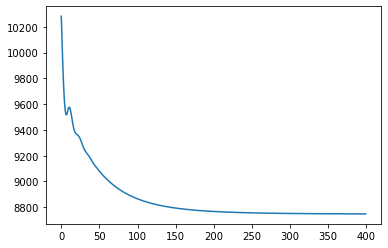

In [72]:
plt.plot(loss)

<AxesSubplot:>

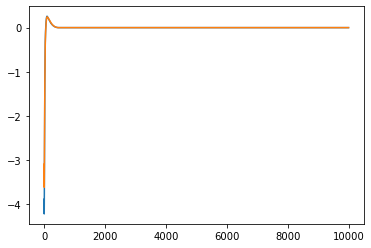

In [73]:
fig, ax = plt.subplots()
glm.eta.plot(t, ax=ax)
glm_fit.eta.plot(t, ax=ax)

In [3]:
from mmdglm.metrics import negative_log_likelihood

In [48]:
dt = 1
r = torch.exp(torch.randn(10000, 20))
mask_spikes = torch.rand(10000, 20) > 0.8

negative_log_likelihood(dt, mask_spikes.float(), r)#, negative_log_likelihood2(dt, mask_spikes, r)

tensor(287986.7188)

In [42]:
%timeit -r10 -n10 negative_log_likelihood(dt, mask_spikes, r)

3.25 ms ± 931 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [43]:
%timeit -r10 -n10 negative_log_likelihood2(dt, mask_spikes, r)

802 µs ± 103 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
